In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Feb 16 09:13:21 2022
@author: ismail.oubarka
"""

from mpi4py import MPI
import timeit

COMM = MPI.COMM_WORLD
SIZE = COMM.Get_size()
RANK = COMM.Get_rank()

from manapy.ddm import readmesh
from manapy.ddm import Domain

from manapy.tools.pyccel_tools import initialisation_gaussian_2d, update_new_value, time_step
                          
from manapy.fvm.pyccel_fvm import (explicitscheme_convective_2d,
                                   explicitscheme_dissipative)

#from manapy.ast import Variable, LinearSystem

import numpy as np
import os

start = timeit.default_timer()

# mesh directory

dim = 2
readmesh('test2.msh', dim=dim, periodic=[0,0,0])

#Create the informations about cells, faces and nodes
domain = Domain(dim=dim)

faces = domain.faces
cells = domain.cells
halos = domain.halos
nodes = domain.nodes

nbnodes = domain.nbnodes
nbfaces = domain.nbfaces
nbcells = domain.nbcells


Starting ....
Number of Cells :  4636
Number of Nodes :  2409


In [3]:
domain.nbcells

4636

In [4]:
#Cells Centre
Cells_centre= [cell[:-1] for cell in cells._center]

In [5]:
import numpy.linalg as LA

def circumcenter(C):
    ax = C[0][0]
    ay = C[0][1]
    bx = C[1][0]
    by = C[1][1]
    cx = C[2][0]
    cy = C[2][1]
    d = 2 * (ax * (by - cy) + bx * (cy - ay) + cx * (ay - by))
    ux = ((ax * ax + ay * ay) * (by - cy) + (bx * bx + by * by) * (cy - ay) + (cx * cx + cy * cy) * (ay - by)) / d
    uy = ((ax * ax + ay * ay) * (cx - bx) + (bx * bx + by * by) * (ax - cx) + (cx * cx + cy * cy) * (bx - ax)) / d
    return (ux, uy)

def dist(x, y):
    x=np.asarray(x)
    y=np.asarray(y)
    return LA.norm(x - y)

In [6]:
def norm2(exact, Sol, volume, nbelements, order):      
    Error = np.zeros(nbelements)
    Ex = np.zeros(nbelements)
    for i in range(nbelements):
        Error[i] = np.fabs(Sol[i]- exact[i]) * volume[i]
        Ex[i] = np.fabs(exact[i]) * volume[i]

    ErrorL2 = np.linalg.norm(Error,ord=order)/np.linalg.norm(Ex,ord=order)
    return ErrorL2

In [7]:
def cell_ver_coor():
    Cells_Cord=[]
    for s in cells._nodeid :
        Cell_Cord =[]
        for i in s :
            Cell_Cord.append(nodes._vertex[i][:-2])
        Cells_Cord.append(Cell_Cord)   
    return Cells_Cord

Cells_Cord = cell_ver_coor()

In [8]:
#Orthocentre
Orthocentre = []
for i in range(nbcells):
    Orthocentre.append(circumcenter(Cells_Cord[i]))

In [9]:
def save_paraview_one_variable(w, cells, nodes, dim, name):
    
    if dim == 2:
        elements = {"triangle": cells}
    elif dim == 3:
        elements = {"tetra": cells}

    points = []
    for i in nodes:
        points.append([i[0], i[1], i[2]])
    
    cells  = np.array(cells)
    points = np.array(points)
    
    data = {"w_v1" : w}
   
    if len(w) == len(cells):
        data = {"w_v1": data}

    if len(w) == len(cells):
        meshio.write_points_cells("results_2_v1/visu"+name+".vtu",
                                  points, elements, cell_data=data, file_format="vtu")
    else:
        meshio.write_points_cells("results_2_v1/visu"+str(w)+".vtu",
                                  points, elements, point_data=data, file_format="vtu")


In [10]:
dist(Orthocentre[0],Orthocentre[1])

104.3231471212392

In [11]:
np.unique(nodes.vertex[:,3])

array([0., 2., 3., 4., 5.])

In [12]:
cells_dict = {"Bottom":[],
             "Right":[],
             "Top":[],
             "Left":[]}
for i in range(nbcells):
    for j in range(3):
        if nodes.vertex[cells.nodeid[i][j]][3] == 2:
#             print("Bottom", i)
            cells_dict["Bottom"] += [i]
            break
        elif nodes.vertex[cells.nodeid[i][j]][3] == 3:
#             print("Right", i)
            cells_dict["Right"] += [i]
            break
        elif nodes.vertex[cells.nodeid[i][j]][3] == 4:
#             print("Top", i)
            cells_dict["Top"] += [i]
            break
        elif nodes.vertex[cells.nodeid[i][j]][3] == 5:
#             print("Left", i)
            cells_dict["Left"] += [i]
            break


In [88]:
import meshio
import numpy as np
def Sol_init(x,y):
    return np.exp((-1*(x**2+y**2))/0.25**2)


u_init = []
for i in range(nbcells):
    if i in (cells_dict["Bottom"] or cells_dict["Right"]):
        u_init += [0]
    elif i in cells_dict["Top"]:
        u_init += [10]
    elif i in cells_dict["Left"]:
        u_init += [20]
    else :
        u_init += [Sol_init( Orthocentre[i][0],Orthocentre[i][1])]
u_init = np.array(u_init)
print(u_init)

#save_n=0
#save_paraview_one_variable(u_init, cells._nodeid, nodes._vertex, 2, "res_VF4"+str(save_n))

[0. 0. 0. ... 0. 0. 0.]


In [16]:
cells.faceid[0]

array([4115, 4918, 4113])

In [17]:
cells.center[0]

array([ 4.84290593, 17.16035315,  0.        ])

In [18]:
target_cells=2
cell1 = faces.cellid[cells.faceid[target_cells]][0]
cell2 = faces.cellid[cells.faceid[target_cells]][1]
cell3 = faces.cellid[cells.faceid[target_cells]][2]

cells.faceid[target_cells],cell1,cell2,cell3

(array([ 809, 5514,  808]),
 array([ 2, 16]),
 array([   2, 1135]),
 array([ 2, 82]))

In [19]:
target_cells=0

cells.faceid[target_cells]

array([4115, 4918, 4113])

In [20]:
face=cells.faceid[target_cells]
k = faces.cellid[face][0]
l = faces.cellid[face][1]

face,k,l

(array([4115, 4918, 4113]), array([ 0, 29]), array([ 0, 36]))

In [182]:
mesure = faces.mesure[face]
mesure

array([2.2979952 , 2.38815291, 2.00925498])

In [21]:
dist1 = dist(Orthocentre[k[0]], Orthocentre[l[1]])
dist1

0.7482953295491088

In [22]:
faces.cellid[cells.faceid[1060][0]]

array([1060, 2983])

In [89]:
# Calcul de dt
somme = []

for i in range(nbcells):
    k = cells.volume[i]
    list_faces = list(cells.faceid[i])
    elem = 0
    for j in range(3):
        mesure1 = faces.mesure[list_faces[j]]
        dist1 = dist(Orthocentre[list(faces.cellid[list_faces[j]])[0]],Orthocentre[list(faces.cellid[list_faces[j]])[1]])
        elem += mesure1/dist1

    somme += [1/k*elem]
lamda = 0.8
D = 1


# Fin de calcul
dt = lamda/(D * max (somme))
print(dt)

save_n = 0
temps=0
T=60
u=np.copy( u_init)
i=0
unew = np.zeros(nbcells)


while temps<=T:
    temps+=dt
    save_n+=1
    
    for j in range(nbcells):
        # solution exat en j
    
        list_faces = cells.faceid[j]
        elem = 0
        for k in range(3):
            mesure1 = faces.mesure[list_faces[k]]
            dist1 = dist(Orthocentre[faces.cellid[list_faces[k]][0]],Orthocentre[faces.cellid[list_faces[k]][1]])
            if j == faces.cellid[list_faces[k]][0]:
                u_diff = u[faces.cellid[list_faces[k]][1]] - u[faces.cellid[list_faces[k]][0]]
            else :
                u_diff = u[faces.cellid[list_faces[k]][0]] - u[faces.cellid[list_faces[k]][1]]
            elem += mesure1*u_diff/dist1
        unew[j] = u[j] - dt/(cells.volume[j]) * (-D)*elem
    u=np.copy(unew)
print(u)

0.11934628745173964
[2.02636808 0.44218745 0.0123227  ... 0.61087327 0.04444479 0.19004378]


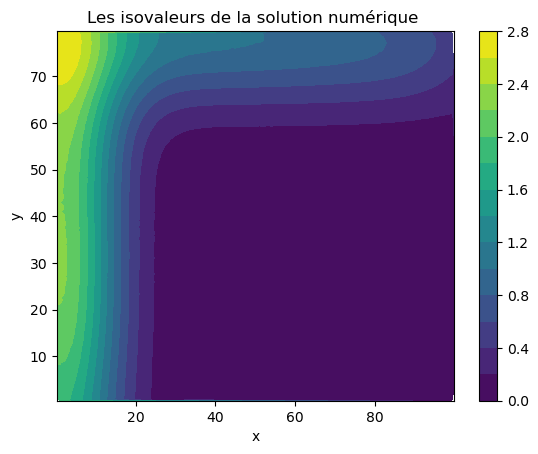

In [90]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation
def plot_isovaleurs(Orthocentre, u):
    triang = Triangulation(Orthocentre[:, 0], Orthocentre[:, 1])
    plt.figure()
    plt.tricontourf(triang, u, levels=14)  # 14 niveaux de contour
    plt.colorbar()
    plt.title("Les isovaleurs de la solution numérique ")
    plt.xlabel('x')
    plt.ylabel('y')
    plt.savefig('solu_vf4_test2t=60_fin.png')
    plt.show()
Orthocentre = np.array(Orthocentre)
plot_isovaleurs(Orthocentre, u)

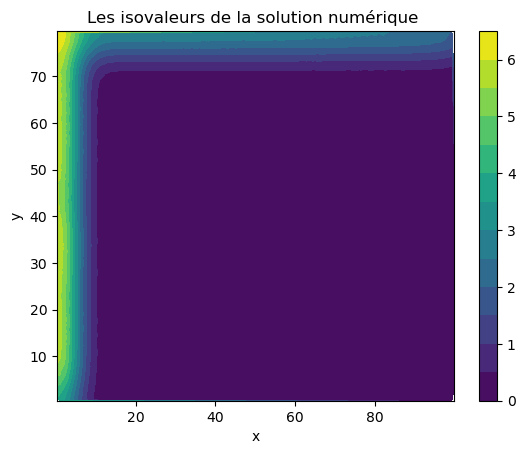

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation
def plot_isovaleurs(Orthocentre, u):
    triang = Triangulation(Orthocentre[:, 0], Orthocentre[:, 1])
    plt.figure()
    plt.tricontourf(triang, u, levels=14)  # 14 niveaux de contour
    plt.colorbar()
    plt.title("Les isovaleurs de la solution numérique ")
    plt.xlabel('x')
    plt.ylabel('y')
    plt.savefig('solu_vf4_test2t=10_fin.png')
    plt.show()
Orthocentre = np.array(Orthocentre)
plot_isovaleurs(Orthocentre, u)

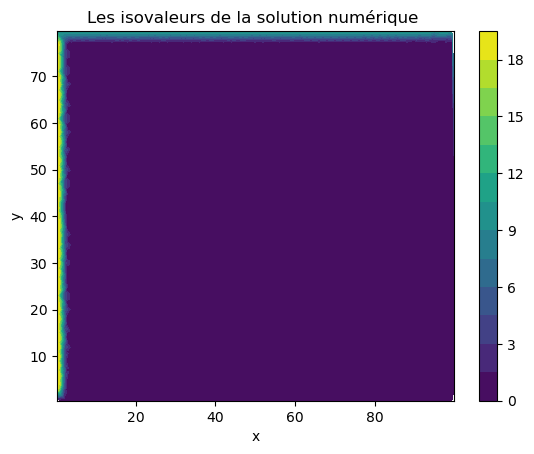

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation
def plot_isovaleurs(Orthocentre, u):
    triang = Triangulation(Orthocentre[:, 0], Orthocentre[:, 1])
    plt.figure()
    plt.tricontourf(triang, u, levels=14)  # 14 niveaux de contour
    plt.colorbar()
    plt.title("Les isovaleurs de la solution numérique ")
    plt.xlabel('x')
    plt.ylabel('y')
    plt.savefig('solu_vf4_test2t=0.15_fin.png')
    plt.show()
Orthocentre = np.array(Orthocentre)
plot_isovaleurs(Orthocentre, u)

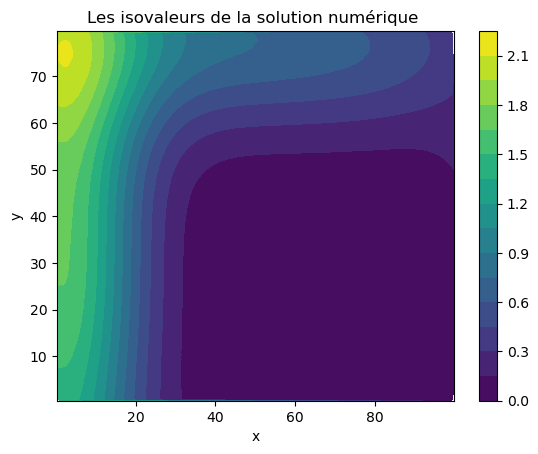

In [79]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation
def plot_isovaleurs(Orthocentre, u):
    triang = Triangulation(Orthocentre[:, 0], Orthocentre[:, 1])
    plt.figure()
    plt.tricontourf(triang, u, levels=14)  # 14 niveaux de contour
    plt.colorbar()
    plt.title("Les isovaleurs de la solution numérique ")
    plt.xlabel('x')
    plt.ylabel('y')
    plt.savefig('solu_vf4_test2t=100_fin.png')
    plt.show()
Orthocentre = np.array(Orthocentre)
plot_isovaleurs(Orthocentre, u)


In [186]:
print(i,temps)

419 50.006094442279206


In [13]:
def save_paraview_one_variable(w, cells, nodes, dim, name):
    
    if dim == 2:
        elements = {"triangle": cells}
    elif dim == 3:
        elements = {"tetra": cells}

    points = []
    for i in nodes:
        points.append([i[0], i[1], i[2]])
    
    cells  = np.array(cells)
    points = np.array(points)
    
    data = {"w" : w}
   
    if len(w) == len(cells):
        data = {"w": data}

    if len(w) == len(cells):
        meshio.write_points_cells("results_2_v2/visu"+name+".vtu",
                                  points, elements, cell_data=data, file_format="vtu")
    else:
        meshio.write_points_cells("results_2_v2/visu"+str(w)+".vtu",
                                  points, elements, point_data=data, file_format="vtu")


In [14]:
import meshio
import numpy as np
def Sol_init():
    return 0


u_init = []
for i in range(nbcells):
    if i in (cells_dict["Bottom"] or cells_dict["Right"]):
        u_init += [0]
    elif i in cells_dict["Top"]:
        u_init += [10]
    elif i in cells_dict["Left"]:
        u_init += [20]
    else :
        u_init += [Sol_init()]
u_init = np.array(u_init)


save_n=0
save_paraview_one_variable(u_init, cells._nodeid, nodes._vertex, 2, "res_VF4"+str(save_n))

In [42]:
def barycentre(C):
    """
    Calcule le barycentre d'un triangle.
    
    Paramètres :
    C (numpy.ndarray) : Un tableau de forme (3, 2) contenant les coordonnées des sommets du triangle.
    
    Retour :
    tuple : Les coordonnées (x, y) du barycentre.
    """
    ax, ay = C[0][0], C[0][1]
    bx, by = C[1][0], C[1][1]
    cx, cy = C[2][0], C[2][1]
    
    # Calcul du barycentre
    x = (ax + bx + cx) / 3.0
    y = (ay + by + cy) / 3.0
    
    return (x, y)

In [43]:
#Orthocentre
Barycentre = []
for i in range(nbcells):
    Barycentre.append(barycentre(Cells_Cord[i]))

In [44]:

def coord_face(k):
   list_faces = list(cells.faceid[k])
   nod_ad =0
   for edge in list_faces:
       triangles = faces.cellid[list_faces[edge]]
       L= []
       for i in triangles:
           L.append(cells.nodeid[i])
       nod_ad = list(set(L[0]) & set(L[1]))
       coord=[nodes._vertex[nod_ad[h]][:-2] for h in range(2)]  
       return coord  

In [45]:
def distance_point_segment(P, A, B):
    # Convertir les points en numpy arrays pour faciliter les calculs
    P = np.array(P)
    A = np.array(A)
    B = np.array(B)
    
    # Vecteur AB
    AB = B - A
    # Vecteur AP
    AP = P - A
    
    # Projection de AP sur AB
    t = np.dot(AP, AB) / np.dot(AB, AB)
    
    # Trouver le point de projection sur le segment
    if t < 0.0:
        point_projection = A
    elif t > 1.0:
        point_projection = B
    else:
        point_projection = A + t * AB
    
    # Calculer la distance entre P et le point de projection
    distance = np.linalg.norm(P - point_projection)
    
    return distance

In [47]:
def get_cells_coords(i):
    ax = Cells_Cord[i][0][0]
    ay = Cells_Cord[i][0][1]
    bx = Cells_Cord[i][1][0]
    by = Cells_Cord[i][1][1]
    cx = Cells_Cord[i][2][0]
    cy = Cells_Cord[i][2][1]
    return [(ax, ay), (bx, by), (cx, cy)]

In [91]:

u_init = []
for i in range(nbcells):
    if i in (cells_dict["Bottom"] or cells_dict["Right"]):
        u_init += [0]
    elif i in cells_dict["Top"]:
        u_init += [10]
    elif i in cells_dict["Left"]:
        u_init += [20]
    else :
        u_init += [Sol_init( Barycentre[i][0],Barycentre[i][1])]
u_init = np.array(u_init)
print(u_init)

[0. 0. 0. ... 0. 0. 0.]


In [61]:
# Calcul de dt
somme = []  
for i in range(nbcells):
    k = cells.volume[i]
    list_faces = list(cells.faceid[i])
    elem = 0

    coord_k = get_cells_coords(i)
    #print('Face ', i)
    #print(coord_k)
    for j in range(3):
        mesure1 = faces.mesure[list_faces[j]]
        cellid_side_j = faces.cellid[list_faces[j]][0]
        coord_j = get_cells_coords(cellid_side_j)
        coord_cellk = set(coord_k)
        coord_cellj = set(coord_j)
        coord_face_j = list(coord_cellk & coord_cellj)

        #print("Voisin ", cellid_side_j)
        #print(coord_j)
        #print(coord_face_j)
       
        distt1 = distance_point_segment(Barycentre[list(faces.cellid[list_faces[j]])[0]], coord_face_j[0], coord_face_j[1])
        distt2 = distance_point_segment(Barycentre[list(faces.cellid[list_faces[j]])[1]], coord_face_j[0], coord_face_j[1])
        dist1= distt1 + distt2

        elem += mesure1/dist1
    somme += [1/k*elem]

lamda = 0.8
D = 1

# Fin de calcul
dt = lamda/(D * max (somme))
print(dt)


save_n = 0
temps=0
T=100
u=np.copy(u_init)
i=0
unew = np.zeros(nbcells)
u_exa_new = np.zeros(nbcells)

while temps<=T:
    temps+=dt
    save_n+=1
    
    for j in range(nbcells):
        #u_exa_new[j] = (1 / (1 + ((4*D*temps)/sigma**2))) * np.exp(-(Barycentre[j][0]**2 + Barycentre[j][1]**2) / (sigma**2 + (4*D*temps)))

        list_faces = list(cells.faceid[j])
        elem = 0

        coord_k = get_cells_coords(j)
        #print('Face ', j)
        #print(coord_k)
        for k in range(3):
            mesure1 = faces.mesure[list_faces[k]]
            cellid_side_j = faces.cellid[list_faces[k]][0]
            coord_j = get_cells_coords(cellid_side_j)
            coord_cellk = set(coord_k)
            coord_cellj = set(coord_j)
            coord_face_j = list(coord_cellk & coord_cellj)
            
            #print("Voisin ", cellid_side_j)
            #print(coord_j)
            #print(coord_face_j)
            
            distt1 = distance_point_segment(Barycentre[list(faces.cellid[list_faces[k]])[0]], coord_face_j[0], coord_face_j[1])
            distt2 = distance_point_segment(Barycentre[list(faces.cellid[list_faces[k]])[1]], coord_face_j[0], coord_face_j[1])
            dist1= distt1 + distt2
            
            if j == faces.cellid[list_faces[k]][0]:
                u_diff = u[faces.cellid[list_faces[k]][1]] - u[faces.cellid[list_faces[k]][0]]
            else :
                u_diff = u[faces.cellid[list_faces[k]][0]] - u[faces.cellid[list_faces[k]][1]]
            elem += mesure1*u_diff/dist1
        unew[j] = u[j] - dt/(cells.volume[j]) * (-D)*elem
    u=np.copy(unew)
    u_exa=np.copy(u_exa_new)

0.16790389372810433


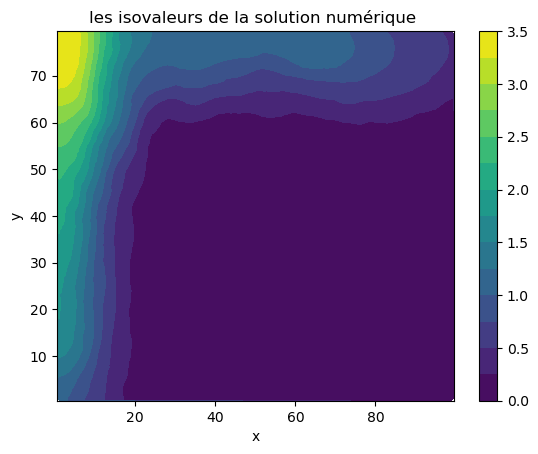

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation
def plot_isovaleurs(Barycentre, u):
    triang = Triangulation(Barycentre[:, 0], Barycentre[:, 1])
    plt.figure()
    plt.tricontourf(triang, u, levels=14)  # 14 niveaux de contour
    plt.colorbar()
    plt.title("les isovaleurs de la solution numérique ")
    plt.xlabel('x')
    plt.ylabel('y')
    plt.savefig('solu_vf4version2_test2t=60_fin.png')
    plt.show()
Barycentre = np.array(Barycentre)
plot_isovaleurs(Barycentre, u)

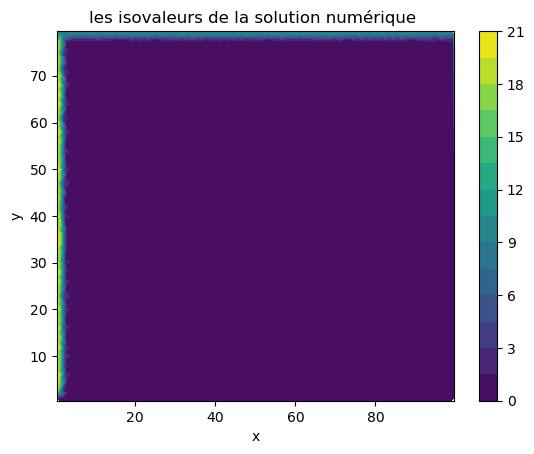

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation
def plot_isovaleurs(Barycentre, u):
    triang = Triangulation(Barycentre[:, 0], Barycentre[:, 1])
    plt.figure()
    plt.tricontourf(triang, u, levels=14)  # 14 niveaux de contour
    plt.colorbar()
    plt.title("les isovaleurs de la solution numérique ")
    plt.xlabel('x')
    plt.ylabel('y')
    plt.savefig('solu_vf4version2_test2t=0.15_fin.png')
    plt.show()
Barycentre = np.array(Barycentre)
plot_isovaleurs(Barycentre, u)

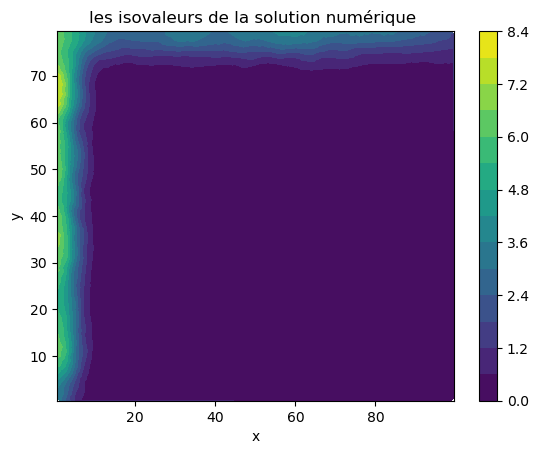

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation
def plot_isovaleurs(Barycentre, u):
    triang = Triangulation(Barycentre[:, 0], Barycentre[:, 1])
    plt.figure()
    plt.tricontourf(triang, u, levels=14)  # 14 niveaux de contour
    plt.colorbar()
    plt.title("les isovaleurs de la solution numérique ")
    plt.xlabel('x')
    plt.ylabel('y')
    plt.savefig('solu_vf4version2_test2t=10_fin.png')
    plt.show()
Barycentre = np.array(Barycentre)
plot_isovaleurs(Barycentre, u)

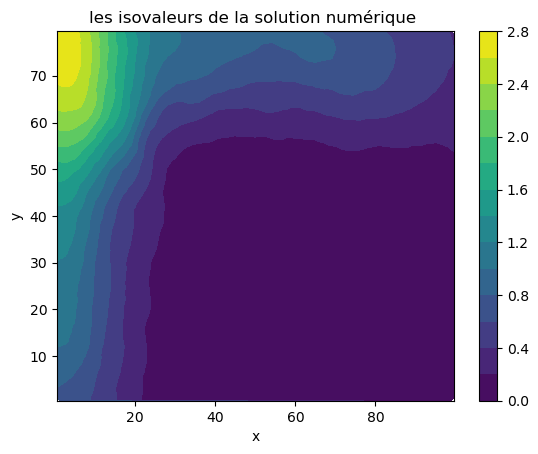

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation
def plot_isovaleurs(Barycentre, u):
    triang = Triangulation(Barycentre[:, 0], Barycentre[:, 1])
    plt.figure()
    plt.tricontourf(triang, u, levels=14)  # 14 niveaux de contour
    plt.colorbar()
    plt.title("les isovaleurs de la solution numérique ")
    plt.xlabel('x')
    plt.ylabel('y')
    plt.savefig('solu_vf4version2_test2t=100_fin.png')
    plt.show()
Barycentre = np.array(Barycentre)
plot_isovaleurs(Barycentre, u)